# 2. Tutorial: Create iML1515 GECKO with modified default values

In the preceding tutorial, an initial GECKO model of iML1515 was developed, incorporating minimal specific parametrization, default turnover numbers for metabolic and transporter reactions, and enzyme compositions derived from the BioCyc online database. While the correlation between predicted and measured growth rates was deemed acceptable, the correlation between predicted and measured protein levels was found to be unsatisfactory. In this tutorial, we will methodically modify parameters to enhance the prediction of protein levels, with a particular focus on transporters. To this end, a more thorough understanding of the organism is essential. The BioCyc/EcoCyc web portal offers valuable insights into *E. coli*, and reviewing relevant implementation details is also advisable. Coupling constraints, which couple reaction flux to protein requirements, are critical to a GECKO model. As previously outlined in the tutorial, these coupling constraints ($\text{CC}_{ij}$) are functions of protein copy number in the catalyzing enzyme ($\text{stoic}_{ij}$), protein molecular weight ($\text{MW}_i$), turnover number ($\text{kcat}_{ij}$), number of active sites ($\text{n_AS}$), and average enzyme saturation ($\text{avg_enz_sat}$).

$\text{CC}_{ij} = \frac{\text{stoic}_{ij} \cdot \text{MW}_i } {(\text{kcat}_{ij} \cdot \text{n_AS}_{ij} \cdot \text{avg_enz_sat})}$

The f2xba method involves the extraction of protein requirements from the gene-product associations configured in the foundational GEM. The average enzyme saturation, applicable to all enzymes, is configured in the ECM configuration file. The protein molecular weight is extracted from UniProt or NCBI online data. In the initial model, protein copy numbers were extracted from BioCyc online data, and the number of active sites were configured based on heuristics. The turnover numbers were set to default values, as specified in the XBA configuration file.

It is important to note that lowering the values of coupling constraint will reduce the amount of protein required to catalyze a specific reaction; alternatively, reaction flux will increase for a given protein investment. An increase in the turnover number will reduce the coupling. Within the scope of this study, transporters are delineated as reactions comprising reactants and products residing in multiple cellular compartments. Turnover numbers for several transporters have been measured and can be extracted from Brenda (https://www.brenda-enzymes.org) (Chang et al., 2021) or BioCyc with references to relevant publications. Given the inherent challenges in measuring turnover numbers for membrane-based transporters, we have established a range of default turnover number values for transporters, contingent on their classification as porins, ABC transporters, and so forth. This approach serves to enhance the accuracy of protein predictions.

While the adjustment of the turnover number appears to be a viable proposition, the modification of the copy number of proteins in multimeric enzymes does not initially appear feasible. However, there are instances where this adjustment could be proposed, particularly in the context of transporters. For instance, in the initial GECKO model, an ABC transporter consists of a transporter component with a fixed stoichiometry of the participating proteins, and one periplasmic binding protein, which is not tightly coupled. Proteomics suggests that the ratio between periplasmic binding proteins and related transporter components is much greater than 1.0. By adjusting the copy numbers of periplasmic binding proteins, we can improve protein predictions. ACP, flavodoxin, or glutaredoxin are some of the coenzymes implemented in the iML1515 GEM model. In instances where these coenzymes are present in a reaction as either a reactant or a product, they are also incorporated into the gene-product association for that specific reaction. For the improved GECKO model, the coenzymes will be removed from the gene-product association when they do not function as a catalyst. This approach results in a reduction of the necessary genes required in the GECKO model compared to the FBA model.

The subsequent parameter modifications were derived iteratively. This process entailed modifying parameters, creating versions of GECKO models, analyzing optimization results, identifying areas for improvement, and reviewing relevant literature.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In the initial step of the present tutorial and the subsequent tutorials, the environment is established for model creation and optimization. The necessary imports are executed, the model names are defined, media conditions are created, and proteomics data is loaded. Subsequently, the configuration data of a previous model, hereafter referred to as the `baseline_model`, is extended to create an improved or more realistic `target_model`.

In [1]:
# Required imports and model names
import os
import re
import time
import pandas as pd
import cobra

from f2xba import XbaModel, EcModel
from f2xba import EcmOptimization, EcmResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_default_GECKO'
target_model = 'iML1515_modified_GECKO'
reference_cond = 'Glucose'

# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr) in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Export kcats values and enzyme composition

The XBA configuration data employed in the creation of the initial GECKO model is updated, and gene products are removed via the table designated as `remove gps`. This includes structural proteins (G_b0957), proteins that are not expressed under normal conditions (G_b1319), and coenzymes that do not act as catalysts. Subsequent to the aforementioned modifications, an in-memory instance of XbaModel is generated, and it is utilized to export two tables, which are subsequently stored in the XLSX format.

The first table encompasses the turnover numbers, while the second table comprises the enzyme composition. The table with turnover numbers is indexed by the reaction identifier (`key`). The `rid` column provides the identifier of the net reaction, respectively the reaction identifier used in the foundational GEM. The direction of the reaction with respect to the net reaction is specified by the `dirxn` column, which can be forward (1) or reverse (-1). The catalyzing enzyme identifier (`enzyme`), the turnover number `kcat_per_s` in units of $s^{-1}$, and other informative columns are also included. The table that enumerates enzyme compositions is indexed by the enzyme identifier (`eid`), and the composition itself specifies the required genes and protein copy numbers. Enzymes can have one or more active sites, and enzymes can be named (`name`). The table also contains optional information columns.

In [2]:
# Create updated XBA parameter file
xba_params = load_parameter_file(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))

data = [['G_b0957', 'ompA (30.4 mg/gP) used in R_H2Otex has mainly a structural'], 
        ['G_b1319', 'ompG used in R_H2Otex, not expressed under lab conditions'],
        # remove proteins used stoichiometrically in iML1515 (add to RBA model as target)
        ['G_b1094', 'acp, Acyl carrier protein, is non-catalytic'],
        ['G_b2582', 'trxC, Thioredoxin-2, is non-catalytic'],
        ['G_b3781', 'trxA, Thioredoxin-1, is non-catalytic'],
        ['G_b2529', 'iscU, scaffold protein for [Fe-S] cluster assembly, is non-catalytic'],
        ['G_b1679', 'sufE, sulfur carrier protein SufE, is non-catalytic'],
        ['G_b1681', 'sufD, FeS cluster assembly protein sufD, is non-catalytic'],
        ['G_b1682', 'sufC, Probable ATP-dependent transporter SufC, is non-catalytic'],
        ['G_b1683', 'sufB, FeS cluster assembly protein sufB, is non-catalytic'],
        ['G_b3860', 'dsbA, Thiol:disulfide interchange protein DsbA, used stoichiometrically'],
        ['G_b2893', 'dsbC, Thiol:disulfide interchange protein DsbC, used stoichiometrically'],
        ['G_b4136', 'dsbD, Thiol:disulfide interchange protein DsbD, used stoichiometrically'],
        ['G_b0604', 'dsbG, Thiol:disulfide interchange protein DsbB, used stoichiometrically'],
        ['G_b1677', 'lpp, Major outer membrane lipoprotein Lpp, used stoichiometrically'],
        ['G_b0684', 'fldA, Flavodoxin-1, used stoichiometrically'],
        ['G_b2895', 'fldb, Flavodoxin-2, used stoichiometrically'],
        ['G_b0849', 'grxA, Glutaredoxin-1, used stoichiometrically'],
        ['G_b1064', 'grxB, Glutaredoxin-2, used stoichiometrically'],
        ['G_b3610', 'grxC, Glutaredoxin-3, used stoichiometrically'],
        ['G_b1654', 'grxD, Glutaredoxin-4, used stoichiometrically'],
       ]

df = pd.DataFrame(data, columns=['gp_id', 'notes']).set_index('gp_id')
xba_params['remove_gps'] = pd.concat((xba_params['remove_gps'], df))

write_parameter_file(os.path.join('data', f'export_xba_parameters.xlsx'), xba_params)

2 table(s) with parameters loaded from data/iML1515_default_GECKO_xba_parameters.xlsx (Thu Mar 20 20:38:08 2025)
2 table(s) with parameters written to  data/export_xba_parameters.xlsx


In [3]:
# Extract kcat and enzyme composition
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'export_xba_parameters.xlsx'))

xba_model.export_kcats(os.path.join('data', f'{baseline_model}_kcats.xlsx'))
xba_model.export_enz_composition(os.path.join('data', f'{baseline_model}_enzyme_composition.xlsx'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
2 table(s) with parameters loaded from data/export_xba_parameters.xlsx (Thu Mar 20 20:48:09 2025)
  22 gene product(s) removed from reactions (1494 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
3855 enzymes extracted from Biocyc
1197 enzyme compositions updated from Biocyc Enzyme data
2221 reactions catalyzed by 1203 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
   0 enzymes removed due to missing kcat values
1877 constraints (+0); 2712 variables (+0); 1494 genes (-22); 5 parameters (+0)
>>> BASELINE XBA model configured!

5357 reaction kcat values exported to data/iML1515_default_GECKO_kcats.xlsx
1203 enzyme compositions exported to data/iML1515_default_GECKO_enzyme_composition.xlsx


In [4]:
# kcats file
load_parameter_file(os.path.join('data', f'{baseline_model}_kcats.xlsx'))['kcats'].head(3)

1 table(s) with parameters loaded from data/iML1515_default_GECKO_kcats.xlsx (Thu Mar 20 20:48:17 2025)


,rid,dirxn,enzyme,kcat_per_s,notes,info_active_sites,info_ecns,info_type,info_genes,info_name,info_reaction
key,,,,,,,,,,,
R_CYTDK2,R_CYTDK2,1,enz_b2066,12.5,XBA model export,1,"2.7.1.213, 2.7.1.48",metabolic,b2066,Cytidine kinase (GTP),M_cytd_c + M_gtp_c => M_cmp_c + M_gdp_c + M_h_c
R_XPPT,R_XPPT,1,enz_b0238,12.5,XBA model export,4,"2.4.2.22, 2.4.2.8",metabolic,b0238,Xanthine phosphoribosyltransferase,M_prpp_c + M_xan_c => M_ppi_c + M_xmp_c
R_HXPRT_iso1,R_HXPRT,1,enz_b0125,12.5,XBA model export,4,2.4.2.8,metabolic,b0125,Hypoxanthine phosphoribosyltransferase (Hypoxa...,M_hxan_c + M_prpp_c => M_imp_c + M_ppi_c


In [5]:
# enzyme composition file
load_parameter_file(os.path.join('data', f'{baseline_model}_enzyme_composition.xlsx'))['enzymes'].tail(3)

1 table(s) with parameters loaded from data/iML1515_default_GECKO_enzyme_composition.xlsx (Thu Mar 20 20:48:18 2025)


,name,composition,active_sites,info_mw_kDa,info_n_reactions,info_sample_rid
eid,,,,,,
enz_b1395,NaN,"gene=b1395, stoic=1.0",1,51.733,1,R_HADPCOADH3
enz_b1007_b1012,enz_b1007_b1012,"gene=b1007, stoic=1.0; gene=b1012, stoic=1.0",1,59.968,1,R_PYROX
enz_b0784_b0785,molybdopterin synthase,"gene=b0784, stoic=2.0; gene=b0785, stoic=2.0",2,51.478,1,R_MPTS


## Step 3: Modify turnover numbers and enzyme composition

The data tables that were exported in the preceding step can be updated by employing a spreadsheet editor. However, this will not be the method employed in this tutorial. Instead, the tables will be updated using Python code.

### 3.1: modify turnover numbers

#### measured values

In instances where turnover numbers have been measured, they will selectively be used to replace the default values employed in the initial GECKO model.

#### outer membrane pores

The FBA model of iML1515 contains 283 transport reactions across the outer membrane that utilize any of four isoenzymes, namely the gene products of b0241/phoE, b0929/ompF, b1377/ompN, and b2215/ompC. Of these, OmpN, with one copy of ompN, has a molecular weight of 41 kD and is the ‘cheapest’ enzyme. The three other outer membrane pores are trimeric with molecular weights of approximately 117 kD (PhoE), 118 kD (OmpF), and 121 kD (OmpC). Two proteins, b0241/phoE and b1377/ompN, were not included in the proteomics data due to their low expression levels under minimal and rich media conditions, as reported by BioCyc. In contrast, b0929/ompF and b2215/ompC were identified as the top 20 most abundant protein masses in the proteomics data.

The GECKO formalism will invariably select the ‘cheapest’ iso-enzyme for a given reaction, i.e., b1377/ompN. By reducing the turnover numbers of all (sub-)reactions utilizing b1377 or b0241, we can redirect traffic to the other two pores, b0929 and b2215. The assignment of distinct turnover numbers to these (sub-)reactions, contingent on the charge state of the transported metabolite, could facilitate a balanced utilization of the two proteins.

#### transporter types

The model encompasses diverse transporter types, including ABC transporters and aquaporins, for which distinct default turnover values have been established.
default kcat values.

#### Python code

It is not necessary to comprehend the Python code presented below in its entirety.

In [6]:
# Load original kcats file and modify selected transporter kcat values
specific_tx_kcats = {'R_NADH16pp': [600.0, 'manual - E. coli, pubmed 672041'], 
                     'R_NADH17pp': [600.0, 'manual - E. coli, pubmed 672041'],
                     'R_NADH18pp': [600.0, 'manual - E. coli, pubmed 672041'],
                     'R_CYTBO3_4pp': [320.0, 'manual - E. coli, pubmed 8382081'], 
                     'R_ATPS4rpp_iso1': [285.0, 'manual - E. coli, pubmed 19411254'],
                     'R_ATPS4rpp_iso2': [285.0, 'manual - E. coli, pubmed 19411254'], 
                     'R_FDH4pp_iso2': [563.0, 'manual - E. coli, pubmed 1099093'], 
                     'R_FDH5pp_iso2': [563.0, 'manual - E. coli, pubmed 1099093'],
                     'R_SUCDi': [85.0, 'manual - E. coli, pubmed 11803023'],
                     'R_SULabcpp_iso2': [100.0, 'manual - adjusted to proteomics'],
                     'R_SO4t2pp': [0.1, 'manual - adjusted to proteomics'],}
rids_low_tx_flux = {'R_MG2tpp', 'R_MG2uabcpp','R_NI2tpp', 'R_NI2uabcpp', 'R_COBALT2tpp'}
enz2omp = {'enz_b0241': 'phoE', 'enz_b0929': 'ompF', 'enz_b1377': 'ompN', 'enz_b2215': 'ompC'}
default_kcats = {'general-tx': 75.0, 'aquaporin': 5000.0, 'pts': 100.0, 'abc': 50.0, 'low_flux': 2.5, 
                 'phoE': 70.0, 'ompN': 30.0, 
                 'ompC (ionic)': 275.0, 'ompC (neutral)': 385.0, 
                 'ompF (ionic)': 275.0, 'ompF (neutral)': 370.0 }

# Create updated kcats file
df_kcats = load_parameter_file(os.path.join('data', f'{baseline_model}_kcats.xlsx'))['kcats']

# Update selected kcats for transporters
updates = {tx_type: 0 for tx_type in default_kcats.keys()} 
n_specific_kcats = 0
for key, row in df_kcats.iterrows():
    if key in specific_tx_kcats:
        df_kcats.at[key, 'kcat_per_s'] = specific_tx_kcats[key][0]
        df_kcats.at[key, 'notes'] = specific_tx_kcats[key][1]
        n_specific_kcats += 1   
    elif row['rid'] in rids_low_tx_flux:
        df_kcats.at[key, 'kcat_per_s'] = default_kcats['low_flux']
        df_kcats.at[key, 'notes'] = 'manual low flux reactions'
        updates['low_flux'] += 1   
    elif row['info_type'] == 'transporter':
        r = xba_model.reactions[row['rid']]
        reactants = list(r.reactants)
        if len(reactants) == 1 and re.match('M_h2o_', reactants[0]):
            tx_type = 'aquaporin'
        elif 'pts' in row['rid']:
            tx_type = 'pts'
        elif 'abc' in row['rid']:
            tx_type = 'abc'
        elif r.compartment == 'e-p':
            tx_type = enz2omp.get(row['enzyme'], 'general-tx')
            species_charge = xba_model.species[reactants[0]].charge
            if tx_type == 'ompF':
                tx_type = 'ompF (neutral)' if species_charge == 0 else 'ompF (ionic)'
            elif tx_type == 'ompC':
                    tx_type = 'ompC (neutral)' if species_charge == 0 else 'ompC (ionic)'    
        else: 
            tx_type = 'general-tx'    
        df_kcats.at[key, 'kcat_per_s'] = default_kcats[tx_type]
        df_kcats.at[key, 'notes'] = f'default for {tx_type} transporter'
        updates[tx_type] += 1

print(f'{len(df_kcats):4d} kcat records in total')
print(f'{sum(updates.values()) + n_specific_kcats:4d} kcat values updated')
print(f'{n_specific_kcats:9d} kcat records set to specific values')
for tx_type, count in updates.items():
    print(f'{count:9d} kcat records set to {default_kcats[tx_type]:6.1f} s-1 for {tx_type} transporter')

# Write updated kcats to file
write_parameter_file(os.path.join('data', f'{target_model}_kcats.xlsx'), {'kcats': df_kcats})

1 table(s) with parameters loaded from data/iML1515_default_GECKO_kcats.xlsx (Thu Mar 20 20:48:17 2025)
5357 kcat records in total
3009 kcat values updated
       11 kcat records set to specific values
      543 kcat records set to   75.0 s-1 for general-tx transporter
       12 kcat records set to 5000.0 s-1 for aquaporin transporter
       27 kcat records set to  100.0 s-1 for pts transporter
      151 kcat records set to   50.0 s-1 for abc transporter
        7 kcat records set to    2.5 s-1 for low_flux transporter
      562 kcat records set to   70.0 s-1 for phoE transporter
      564 kcat records set to   30.0 s-1 for ompN transporter
      327 kcat records set to  275.0 s-1 for ompC (ionic) transporter
      239 kcat records set to  385.0 s-1 for ompC (neutral) transporter
      327 kcat records set to  275.0 s-1 for ompF (ionic) transporter
      239 kcat records set to  370.0 s-1 for ompF (neutral) transporter
1 table(s) with parameters written to  data/iML1515_modified_GECKO_

### 3.2: modify enzyme compositions

According to proteomics data, the copy number of loosely coupled proteins required in ATP binding cassette (ABC) and phosphotransferase system (PTS) transport processes should be modified. Periplasmic binding proteins are identified by name or gene locus. The loosely attached components of PTS transporters are identified by gene locus. The number of active sites is modified for large multienzyme complexes.

In [7]:
# Load enzyme composition template file
df_enz_comp = load_parameter_file(os.path.join('data', f'{baseline_model}_enzyme_composition.xlsx'))['enzymes']
    
# Collect genes related to periplasmic binding proteins. Accessing protein data in xba_model.
binding_proteins = {'b1857', 'b0698', 'b2177'}
for uid, p in xba_model.proteins.items():
    if re.match('.*binding.*protein', p.name) and 'ATP-binding' not in p.name:
        binding_proteins.add(p.locus)

# Update composition of selected enzymes
pts_update = {'b1101':1.0, 'b1817': 7.0, 'b2415': 9.0, 'b2416': 4.0, 'b2417': 12.0}
enz_modified = set()
for eid, row in df_enz_comp.iterrows():
        composition = []
        for kv in row['composition'].split(';'):
            gene = re.match(r'.*gene=(b\d{4})', kv).group(1)
            stoic = float(re.match(r'.*stoic=([0-9\.])', kv).group(1))
            if 'abc' in row['info_sample_rid'] and gene in binding_proteins:
                stoic = 50.0
                enz_modified.add(eid)
            elif gene in pts_update:
                stoic = pts_update[gene]
                enz_modified.add(eid)
            composition.append(f'gene={gene}, stoic={stoic}')
        if eid in enz_modified:
            df_enz_comp.at[eid, 'composition'] = '; '.join(composition)
            df_enz_comp.at[eid, 'notes'] = 'enzyme composition manually updated'
print(f'{len(df_enz_comp):4d} enzymes in total')
print(f'{len(enz_modified):4d} enzyme compositions manually updated')

# update number of active sites in PDH and AGKDH
df_enz_comp.at['enz_b0114_b0115_b0116', 'active_sites'] = 24  # PDH
df_enz_comp.at['enz_b0116_b0726_b0727', 'active_sites'] = 24  # AKGDH

write_parameter_file(os.path.join('data', f'{fba_model}_enzyme_composition_updated.xlsx'), 
                     {'enzymes': df_enz_comp})

1 table(s) with parameters loaded from data/iML1515_default_GECKO_enzyme_composition.xlsx (Thu Mar 20 20:48:18 2025)
1203 enzymes in total
  62 enzyme compositions manually updated
1 table(s) with parameters written to  data/iML1515_enzyme_composition_updated.xlsx


## Step 4: Create XBA and ECM configuration files

The creation of XBA and ECM configuration files for the target model is achieved through the extension of the configuration files from the baseline model. Rather than utilizing the ECM configuration parameter `pm2totpm_val_or_paxdb` to define the mass fraction of modeled protein to total protein, an alternative approach is explored, employing a protein abundance dataset for *E. coli* that is downloaded from PaxDB.

### 4.1 download PaxDb file

In order to proceed, it is necessary to navigate to the 'PaxDb: Protein Abundance Database web portal' (https://pax-db.org) and select the species '*Escherichia coli* str. K-12 substr. MG1655'. Subsequently, the dataset for '*E. coli* - Whole organism (Integrated)' (511145-WHOLE_ORGANISM-integrated.txt) should be downloaded. The downloaded file should then be stored in the `.\data` folder.

#### PaxDb files for other organisms:

f2xba anticipates that the gene product references contained within the protein abundance dataset correspond to the gene labels employed in the model. In instances where PaxDb lacks a protein abundance dataset for a particular organism, it is imperative to ascertain the proportion of modeled protein mass to total protein mass and allocate this value to the ECM configuration parameter designated as `pm2totpm_val_or_paxdb`.

### 4.2 update XBA and ECM configuration files

#### XBA configuration

The XBA configuration file has been updated, with the following changes: Within the `generals` table, the `biocyc_org_prefix` parameter has been substituted with the `enzyme_comp_fname` parameter, thereby referencing the updated enzyme composition file. Additionally, the `kcats_fname` parameter has been incorporated, referencing the updated turnover numbers file. The new table, `modify_attributes`, is used to modify specific model parameters. The spontaneous reaction 'R_MG2t3_2pp' is blocked to enforce active transport through alternative reactions, and the reaction 'R_GLCDpp' is blocked since it requires the cofactor pyrroloquinoline quinone (PQQ), which is not part of the specified medium conditions.

#### ECM configuration

The ECM configuration involves the update of the parameters `pm2totpm_val_or_paxdb`, now referencing the PacDb file, and the adjustment of the `avg_enz_sat`.

In [8]:
# Update XBA parameter file
xba_params = load_parameter_file(os.path.join('data', f'export_xba_parameters.xlsx'))

xba_params['general'].drop(index='biocyc_org_prefix', inplace=True)
data = [['kcats_fname', os.path.join('data', f'{target_model}_kcats.xlsx')], 
        ['enzyme_comp_fname', os.path.join('data', f'{fba_model}_enzyme_composition_updated.xlsx')]]
df = pd.DataFrame(data, columns=['parameter', 'value']).set_index('parameter')
xba_params['general'] = pd.concat((xba_params['general'], df))

data = [['R_GLCDpp', 'reaction', 'fbc_upper_bound', 'cobra_0_bound',
         'block, as both isoenzymes gcd/b0124 and ylil/b0837 require PQQ as cofactor'],
        ['R_MG2t3_2pp', 'reaction', 'fbc_upper_bound', 'cobra_0_bound',
         'block, as this reaction has no enzyme attached'],]
cols=['id', 'component', 'attribute', 'value', 'notes']
xba_params['modify_attributes'] = pd.DataFrame(data, columns=cols).set_index('id')

write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

# Update ECM parameter file
ecm_params = load_parameter_file(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'),['general'])

ecm_params['general'].at['avg_enz_sat', 'value'] = 0.90
paxdb_fname = os.path.join('data', '511145-WHOLE_ORGANISM-integrated.txt')
ecm_params['general'].at['pm2totpm_val_or_paxdb', 'value'] = paxdb_fname

write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

2 table(s) with parameters loaded from data/export_xba_parameters.xlsx (Thu Mar 20 20:48:09 2025)
3 table(s) with parameters written to  data/iML1515_modified_GECKO_xba_parameters.xlsx
1 table(s) with parameters loaded from data/iML1515_default_GECKO_ecm_parameters.xlsx (Thu Mar 20 20:38:16 2025)
1 table(s) with parameters written to  data/iML1515_modified_GECKO_ecm_parameters.xlsx


## Step 5: Create GECKO model

This code section bears a strong resemblance to the preceding tutorial, with two notable exceptions. Firstly, validation of the model is no longer performed. Secondly, the model is not exported as a spreadsheet.

In [9]:
# Create GECKO model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))

ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'))
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_modified_GECKO_xba_parameters.xlsx (Thu Mar 20 20:49:15 2025)
   2 attributes on reaction instances updated
  22 gene product(s) removed from reactions (1494 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
1 table(s) with parameters loaded from data/iML1515_enzyme_composition_updated.xlsx (Thu Mar 20 20:48:35 2025)
1203 enzyme compositions updated from data/iML1515_enzyme_composition_updated.xlsx
2221 reactions catalyzed by 1203 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
1 table(s) with parameters loaded from data/iML1515_modified_GECKO_kcats.xlsx (Thu Mar 20 20:48:35 2025)
5357 kcat values updated from data/iML1515_modified_GECKO_kcats.xlsx
   0 enzymes removed due to missing kcat values
1877 constraints (+0);

True

---
---
## Step 4: Load and optimize GECKO model (cobrapy)

In [10]:
# Load model using cobrapy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

# Load SBML model with EcmOptimization
eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')
print(f'Duration: {time.time()-start:.1f} s')

Set parameter Username
Set parameter LicenseID to value 2585731
Academic license - for non-commercial use only - expires 2025-11-16
SBML model loaded by sbmlxdf: SBML_models/iML1515_modified_GECKO.xml (Thu Mar 20 20:49:39 2025)
total modeled protein: 306.59 mg/gDW, average saturation level: 0.9
Duration: 18.1 s


Acetate                  : pred gr: 0.401 h-1 vs. exp 0.290, diff:  0.111
Glycerol                 : pred gr: 0.801 h-1 vs. exp 0.470, diff:  0.331
Fructose                 : pred gr: 0.665 h-1 vs. exp 0.540, diff:  0.125
L-Malate                 : pred gr: 0.843 h-1 vs. exp 0.550, diff:  0.293
Glucose                  : pred gr: 0.661 h-1 vs. exp 0.660, diff:  0.001
Glucose 6-Phosphate      : pred gr: 0.722 h-1 vs. exp 0.780, diff: -0.058


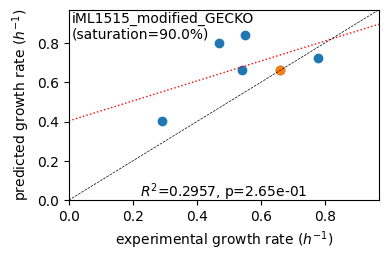

Protein mass fractions:
Acetate                  : r² = 0.1066, p = 3.09e-26 ( 999 proteins lin scale)
Glycerol                 : r² = 0.0733, p = 2.99e-18 ( 999 proteins lin scale)
Fructose                 : r² = 0.1878, p = 5.49e-47 ( 999 proteins lin scale)
Glucose                  : r² = 0.1358, p = 1.71e-33 ( 999 proteins lin scale)
Acetate                  : r² = 0.2468, p = 1.15e-20 ( 309 proteins log scale)
Glycerol                 : r² = 0.1908, p = 7.10e-16 ( 310 proteins log scale)
Fructose                 : r² = 0.2040, p = 4.86e-17 ( 311 proteins log scale)
Glucose                  : r² = 0.2045, p = 1.56e-17 ( 320 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 524.3 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 405.3 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 119.0 mg/gP predicted
      49

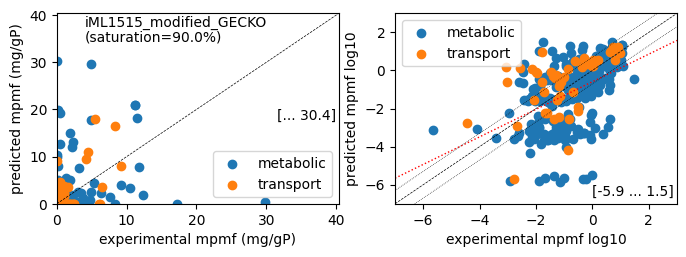

1 file(s) exported for "Load reaction data" into Escher maps
Duration: 3.7 s


In [11]:
# Optimize model using cobrapy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    ecm.medium = medium 
    solution = ecm.optimize()
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')

# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))
print(f'Duration: {time.time()-start:.1f} s')

## (Optional) Track progress

In [12]:
import scipy
import numpy as np

number = 2
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Mar 20 20:43:52 2025)
1 table(s) with parameters written to  protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135805,0.204476,999,320


## Closing remarks

A few parameters, primarily those associated with transporters, were modified, leading to substantial improvements in the predicted protein levels. The modifications were made based on a comprehensive understanding of the organism and the manner in which the reaction network is modeled. This included adjustments to transporter turnover numbers, the enzyme composition of transporters, and the number of active sites for large multienzyme complexes. Additionally, coenzymes that did not function as catalysts were removed from the modeled gene products. It should be noted that metabolic reactions continue to be configured with the default turnover number. In the subsequent tutorial, we will utilize an AI-based tool to predict the turnover numbers of all metabolic reactions.

---
---
## (Alternative) gurobipy - model optimization

In [13]:
# Load model using gurobipy
fname = os.path.join('SBML_models', f'{target_model}.xml')
eo = EcmOptimization(fname)
total_protein = eo.get_variable_bounds('V_PC_total')[1]
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')

SBML model loaded by sbmlxdf: SBML_models/iML1515_modified_GECKO.xml (Thu Mar 20 20:49:39 2025)
LP Model of iML1515_GECKO
7343 variables, 3372 constraints, 28438 non-zero matrix coefficients
total modeled protein: 306.59 mg/gDW, average saturation level: 0.9


Acetate                  : pred gr: 0.401 h-1 vs. exp 0.290, diff:  0.111
Glycerol                 : pred gr: 0.801 h-1 vs. exp 0.470, diff:  0.331
Fructose                 : pred gr: 0.665 h-1 vs. exp 0.540, diff:  0.125
L-Malate                 : pred gr: 0.843 h-1 vs. exp 0.550, diff:  0.293
Glucose                  : pred gr: 0.661 h-1 vs. exp 0.660, diff:  0.001
Glucose 6-Phosphate      : pred gr: 0.722 h-1 vs. exp 0.780, diff: -0.058


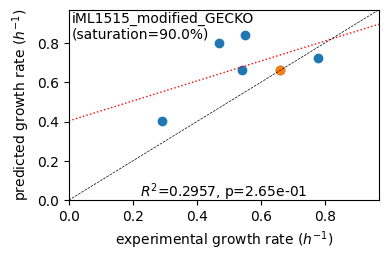

Protein mass fractions:
Acetate                  : r² = 0.1066, p = 3.09e-26 ( 999 proteins lin scale)
Glycerol                 : r² = 0.0733, p = 2.99e-18 ( 999 proteins lin scale)
Fructose                 : r² = 0.1878, p = 5.49e-47 ( 999 proteins lin scale)
Glucose                  : r² = 0.1358, p = 1.71e-33 ( 999 proteins lin scale)
Acetate                  : r² = 0.2468, p = 1.15e-20 ( 309 proteins log scale)
Glycerol                 : r² = 0.1908, p = 7.10e-16 ( 310 proteins log scale)
Fructose                 : r² = 0.2040, p = 4.86e-17 ( 311 proteins log scale)
Glucose                  : r² = 0.2045, p = 1.56e-17 ( 320 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 524.3 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 405.3 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 119.0 mg/gP predicted
      49

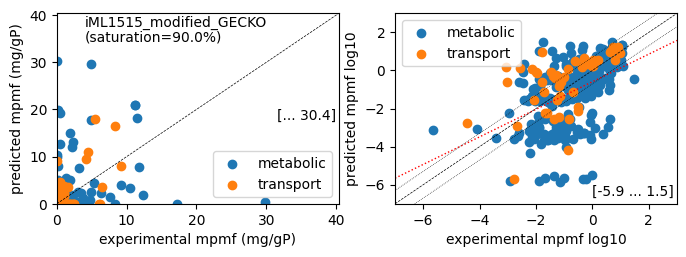

1 file(s) exported for "Load reaction data" into Escher maps


In [14]:
# Optimize model using gurobipy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    eo.set_medium(medium)
    solution = eo.optimize()

    if solution.status == 'optimal':
        pred_results[cond] = solution
        gr = solution.objective_value
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')
        
# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))

---
---
## References

- Chang, A., Jeske, L., Ulbrich, S., Hofmann, J., Koblitz, J., Schomburg, I., Neumann-Schaal, M., Jahn, D., & Schomburg, D. (2021). BRENDA, the ELIXIR core data resource in 2021: new developments and 